In [1]:
import keras
from keras.layers import Flatten, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from scipy import spatial
from matplotlib.patches import Rectangle
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
%matplotlib inline

Using TensorFlow backend.
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,


In [2]:
#full image view and full image as array
img = image.load_img("ny_resized.jpg")
full_img = image.img_to_array(img)

Functions

In [3]:
#return distance between vector points
#Utils
def vector_dist(v1, v2):
    return spatial.distance.cdist(v1, v2)

In [4]:
#return value from x/y index
#Utils
def return_xy(randx, randy, idx):
    t_x = randx[idx : idx + 1]
    t_y = randy[idx : idx + 1]
    return int(t_x), int(t_y)

In [5]:
#return subarray from full image
#Utils and search
def get_img_slice(t_img, x, y, model_width):
    t_array = t_img[y + half_est_location: y + model_width + est_location - half_est_location, x + half_est_location: x + model_width + est_location - half_est_location, :]
    return t_array

In [6]:
#in middle pixel, returns starting and ending slice points
#Utils
def start_lines(pix_x, pix_y):
    x_start = pix_x - 100 - 112 
    x_finish = pix_x + 100 + 112
    y_start = pix_y - 100 - 112 
    y_finish = pix_y + 100 + 112
    return x_start, x_finish, y_start, y_finish

In [7]:
#return model
#model
def get_model():
    res_model = ResNet50(include_top=False, weights = 'imagenet', input_shape = (224, 224, 3))
    #res_model = ResNet50(include_top=False, weights = 'imagenet', input_shape = (224, 224, 3), pooling = 'max')
    max_pool = MaxPooling2D()(res_model.output)
    max_pool2 = MaxPooling2D()(max_pool)
    flat_1 = Flatten()(max_pool2)
    #flat_1 = Flatten()(max_pool)
    model = Model(inputs = res_model.inputs, outputs = flat_1)
    model.compile(optimizer = 'rmsprop', loss = "categorical_crossentropy", metrics = ['accuracy'])
    return model

In [8]:
#return prediction
#model
def get_pred(t_img):
    t_test = image.img_to_array(t_img)
    t_test = np.expand_dims(t_test, axis=0)
    t_test = preprocess_input(t_test)
    return model.predict(t_test)

In [135]:
#random search returns x, y coordinates
#search
def std_dev_search(img, x_start, x_finish, y_start, y_finish, num_samples):
    rand_x = np.random.randint(x_start, x_finish, num_samples)
    rand_y = np.random.randint(y_start, y_finish, num_samples)
    dist_array = []
    for i in range(len(rand_x)):
        test_slice = get_img_slice(img, rand_x[i], rand_y[i], model_width)
        test_img = image.array_to_img(test_slice)
        dist_array.append(vector_dist(goal_pred, get_pred(test_img))[0][0])
    #print('STD',np.std(dist_array), 'Mean',np.mean(dist_array), 'Value',dist_array[np.argmin(dist_array): np.argmin(dist_array)+1][0], 'arg',np.argmax(dist_array))
    if dist_array[np.argmin(dist_array): np.argmin(dist_array)+1] < (np.mean(dist_array) - (np.std(dist_array))):
        return return_xy(rand_x, rand_y, np.argmin(dist_array))
    else:
        print('do it again')
        #return return_xy(rand_x, rand_y, np.argmin(dist_array))

In [140]:
def deviation_assisted_search():
    x, y = std_dev_search(tee_ny, rand_x_start, rand_x_fin, rand_y_start, rand_y_fin, 25)
    x, y = std_dev_search(tee_ny, x - 100, x + 100, y - 100, y + 100, 25)
    x, y = std_dev_search(tee_ny, x - 50, x + 50, y - 50, y + 50, 25)
    x, y = std_dev_search(tee_ny, x - 25, x + 25, y - 25, y + 25, 25)
    x, y = std_dev_search(tee_ny, x - 10, x + 10, y - 10, y + 10, 25)
    x, y = narrow_search(tee_ny, x - 5, x + 6, y - 5, y + 6)
    return x, y

In [52]:
#random search returns x, y coordinates
#search
def random_search(img, x_start, x_finish, y_start, y_finish, num_samples):
    rand_x = np.random.randint(x_start, x_finish, num_samples)
    rand_y = np.random.randint(y_start, y_finish, num_samples)
    dist_array = []
    for i in range(len(rand_x)):
        test_slice = get_img_slice(img, rand_x[i], rand_y[i], model_width)
        test_img = image.array_to_img(test_slice)
        dist_array.append(vector_dist(goal_pred, get_pred(test_img))[0][0])
    print(np.std(dist_array), np.mean(dist_array), dist_array[np.argmin(dist_array): np.argmin(dist_array)+1], np.argmax(dist_array))
    return return_xy(rand_x, rand_y, np.argmin(dist_array))

In [10]:
#search
def narrow_search(img, x_start, x_finish, y_start, y_finish):
    dist_array = []
    t_i = []
    t_j = []
    for i in range(x_start, x_finish):
        for j in range(y_start, y_finish):
            test_slice = get_img_slice(img, i, j, model_width)
            test_img = image.array_to_img(test_slice)
            dist_array.append(vector_dist(goal_pred, get_pred(test_img))[0][0])
            t_i.append(i)
            t_j.append(j)
    
    return t_i[np.argmin(dist_array): np.argmin(dist_array) + 1][0], t_j[np.argmin(dist_array): np.argmin(dist_array) + 1][0] 

In [137]:
#random search of narrowing windows
#search
def narrowing_search():
    x, y = random_search(tee_ny, rand_x_start, rand_x_fin, rand_y_start, rand_y_fin, 200)
    x, y = random_search(tee_ny, x - 100, x + 100, y - 100, y + 100, 100)
    x, y = random_search(tee_ny, x - 50, x + 50, y - 50, y + 50, 100)
    x, y = narrow_search(tee_ny, x - 5, x + 6, y - 5, y + 6)
    return x, y

In [12]:
#runs random search twice (narrowing window), then runs narrow search 
#search
#def target_search():
    #x, y = random_search(tee_ny, x_start_num, x_finish_num, y_start_num, y_finish_num)
    #x, y = random_search(tee_ny, rand_x_start, rand_x_fin, rand_y_start, rand_y_fin, 500)
    #print(x,y)
    #x, y = random_search(tee_ny, x - 50, x + 50, y - 50, y + 50, 500)
    #print(x,y)
    #x, y = narrow_search(tee_ny, x - 5, x + 6, y - 5, y + 6)
    #return x, y

Definitions

In [13]:
model = get_model()

/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [14]:
model_width = 224
half_model_width = int(224 * .5)
est_location = 200
half_est_location = int(est_location * .5)

In [144]:
#actual locations, random locations, pix locations are visual points of interest
pix_x, pix_y = 639, 750
#pix_x, pix_y = 465, 635
#pix_x, pix_y = 1211, 1038
rand_pix_x = np.random.randint(pix_x - half_est_location, pix_x + half_est_location)
rand_pix_y = np.random.randint(pix_y - half_est_location, pix_y + half_est_location)
x_start_num, x_finish_num, y_start_num, y_finish_num= start_lines(pix_x, pix_y)
rand_x_start, rand_x_fin, rand_y_start, rand_y_fin = start_lines(rand_pix_x, rand_pix_y)

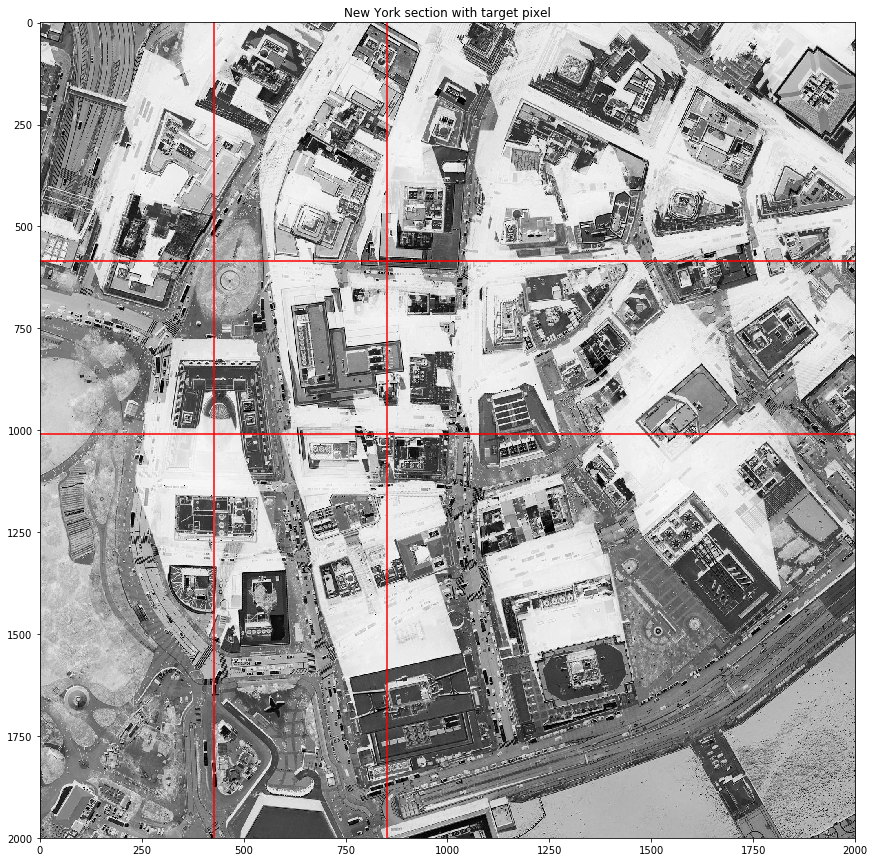

In [145]:
#return subarray (tee_ny) from full image, arbitrarily chosen
tee_ny = full_img[8250: 10250, 5000:  7000, :]
tee_ny_img = image.array_to_img(tee_ny)
plt.figure(figsize = (15,15))
plt.axvline(x= rand_x_start, color= 'red')
plt.axvline(x= rand_x_fin, color= 'red')
plt.axhline(y= rand_y_start, color= 'red')
plt.axhline(y= rand_y_fin, color= 'red')
plt.title('New York section with target pixel')
plt.imshow(tee_ny);

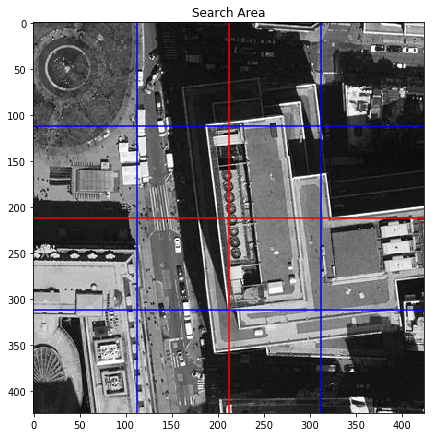

In [146]:
search_img = tee_ny[rand_y_start : rand_y_fin, rand_x_start: rand_x_fin, :]
search_img = image.array_to_img(search_img)
plt.figure(figsize = (7,10))
plt.title('Search Area')
plt.axvline(x = 212, color = 'red')
plt.axhline(y = 212, color = 'red')
plt.axvline(x = 212 - 100, color = 'blue')
plt.axhline(y = 212 + 100, color = 'blue')
plt.axvline(x = 212 + 100, color = 'blue')
plt.axhline(y = 212 - 100, color = 'blue')
#plt.axis('off')
plt.imshow(search_img);

(224, 224, 3)


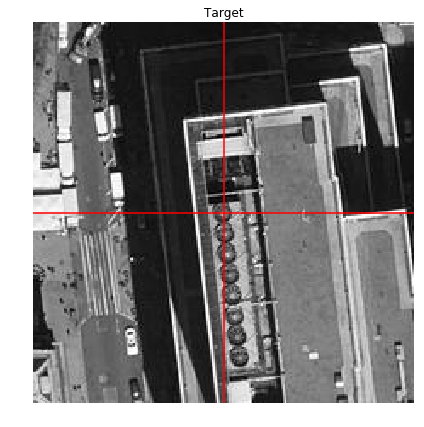

In [147]:
#Target Image and target to predict
x_img_array = get_img_slice(tee_ny, x_start_num, y_start_num, model_width)
print(x_img_array.shape)
x_img = image.array_to_img(x_img_array)
goal_pred = get_pred(x_img)
plt.figure(figsize = (7,7))
plt.title('Target')
plt.axvline(x= model_width * .5, color= 'red')
plt.axhline(y= model_width * .5, color= 'red')
plt.axis('off')
plt.imshow(x_img);

In [ ]:
#x, y = target_search() 
#x, y = narrowing_search() 
x, y = deviation_assisted_search()
z_img = get_img_slice(tee_ny, x, y, model_width)
z_img = image.array_to_img(z_img)
plt.figure(figsize = (7,7))
plt.axvline(x = model_width * .5, color = 'red')
plt.axhline(y = model_width * .5, color = 'red')
plt.imshow(z_img);

In [ ]:
x + half_model_width + half_est_location, y + half_model_width + half_est_location

In [ ]:
pix_x, pix_y

In [61]:
#search
num_samples = 50
rand_x = np.random.randint(rand_x_start, rand_x_fin, num_samples)
rand_y = np.random.randint(rand_y_start, rand_y_fin, num_samples)
dist_array = []
for i in range(len(rand_x)):
    test_slice = get_img_slice(tee_ny, rand_x[i], rand_y[i], model_width)
    test_img = image.array_to_img(test_slice)
    dist_array.append(vector_dist(goal_pred, get_pred(test_img))[0][0])
print(np.std(dist_array), np.mean(dist_array), dist_array[np.argmin(dist_array): np.argmin(dist_array)+1], np.argmax(dist_array))

(17.156007170089936, 197.72074522622989, [132.44728507091145], 46)


In [63]:
x, y = rand_x[np.argmin(dist_array):np.argmin(dist_array)+1], rand_y[np.argmin(dist_array):np.argmin(dist_array)+1]

In [133]:
x + half_model_width + half_est_location, y + half_model_width + half_est_location

(493, 635)

In [68]:
if dist_array[np.argmin(dist_array): np.argmin(dist_array)+1] < (np.mean(dist_array) - (2*np.std(dist_array))):
    return return_xy(rand_x, rand_y, np.argmin(dist_array))
else:
    print('do it again')

true
